## Running LAS

In [13]:
import numpy as np
from pyscf import gto, scf, lib, mcscf
import math
import time
import os
from tools import sign_control, util
from tools.util import load_pkl, dump_pkl
from systems.hcircle import HCircle

NUM_H = 32 #total number of hydrogens
NUM_H_PER_FRAG = 8 #number of hydrogens/fragment
DIST = 1.4 #bond distance

geom = HCircle(DIST,NUM_H,NUM_H_PER_FRAG,fn="logs/hcircle.log")
las = geom.make_las_state_average()

#Build LAS states
print("Initiating LAS Model Space...")
start = time.perf_counter()
las.lasci_()
las.ci = sign_control.fix_sign(las) #sign fixing
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")
las.dump_spaces()

#Run LASSI
print("Running LASSI...")
start = time.perf_counter()
from mrh.my_pyscf import lassi
lsi = lassi.LASSI(las)
energies_lassi, civecs_lassi = lsi.kernel()
civecs_lassi = lsi.get_sivec_vacuum_shuffle(state=0) #sign fixing
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds") #Logged to hcircle.log

las_charges = util.las_charges(las)
data = {"energies_lassi":energies_lassi,
        "civecs":civecs_lassi,
        "charges":las_charges,
        "nfrags":geom.nfrags,
        "dist":geom.dist,
        "mf_coeff":geom.mf_coeff,
        "mf_occ":geom.mf_occ,
        "mf_ene":geom.mf_ene,
       }
d = int(DIST*10)
data_name = f"logs/h{NUM_H}_frag{NUM_H_PER_FRAG}H_dist{d}_lsi"
dump_pkl(data,f"{data_name}.pkl")

overwrite output file: logs/hcircle.log


WARN: HOMO -0.0983244949178825 >= LUMO -0.0983244949178824


Initiating LAS Model Space...
Done. Time elapsed: 190.4828367161099 seconds
Running LASSI...
Done. Time elapsed: 5.716445917030796 seconds


## Plotting Band Structure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,LASSI
IP,8.52
EA,-4.00
GAP,12.52


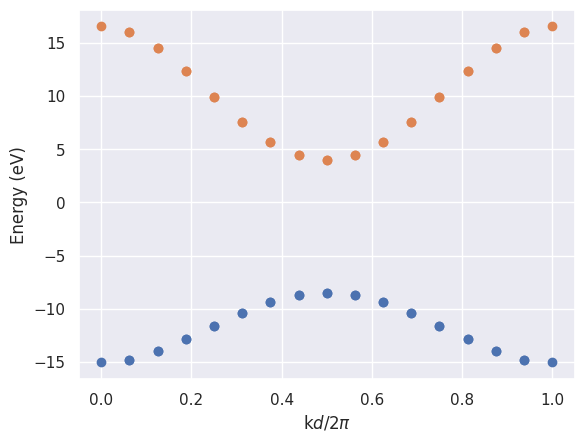

In [14]:
%load_ext autoreload
%autoreload 2

from tools import bandh
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tools.util import load_pkl, LASdata
sns.set()

las = LASdata(pkl_fn="logs/h32_frag2H_dist14_lsi.pkl",pdft=False)
df = las.make_bands()
np.round(df,2)

,LASSI
IP,7.92
EA,-3.37
GAP,11.28


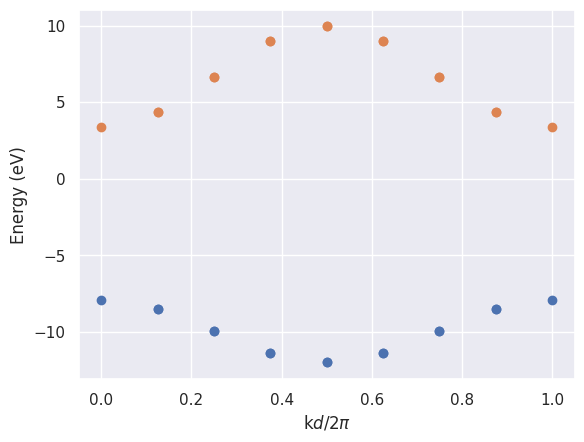

In [15]:
las = LASdata(pkl_fn="logs/h32_frag4H_dist14_lsi.pkl",pdft=False)
df = las.make_bands()
np.round(df,2)

,LASSI
IP,7.73
EA,-3.23
GAP,10.96


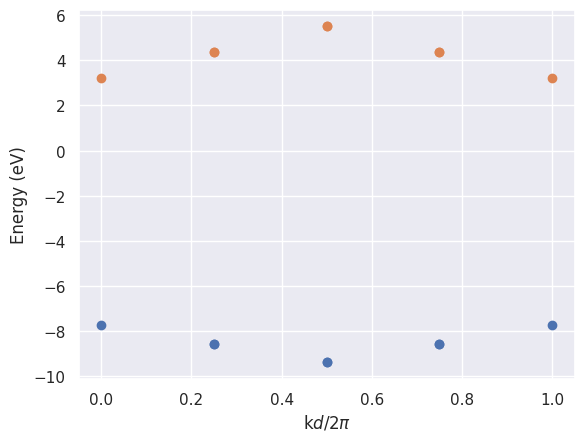

In [16]:
las = LASdata(pkl_fn="logs/h32_frag8H_dist14_lsi.pkl",pdft=False)
df = las.make_bands()
np.round(df,2)

## Adding Comparisons

In [49]:
from tools.util import LASdata, DMRGdata, PeriodicData
import pandas as pd
df = pd.DataFrame()

per = PeriodicData("logs/periodic_HF_frag2H_14_k16.csv")
df.loc["HF (2H)","IP"] = per.ip()
df.loc["HF (2H)","EA"] = per.ea()
per = PeriodicData("logs/periodic_HF_frag4H_14_k16.csv")
df.loc["HF (4H)","IP"] = per.ip()
df.loc["HF (4H)","EA"] = per.ea()
per = PeriodicData("logs/periodic_PBE_frag2H_14_k16.csv")
df.loc["PBE (2H)","IP"] = per.ip()
df.loc["PBE (2H)","EA"] = per.ea()
per = PeriodicData("logs/periodic_HSE06_frag2H_14_k16.csv")
df.loc["HSE06 (2H)","IP"] = per.ip()
df.loc["HSE06 (2H)","EA"] = per.ea()
las = LASdata(pkl_fn="logs/h32_frag2H_dist14_lsi.pkl",pdft=False)
df.loc["LAS (2H)","IP"] = las.ip()
df.loc["LAS (2H)","EA"] = las.ea()
las = LASdata(pkl_fn="logs/h32_frag4H_dist14_lsi.pkl",pdft=False)
df.loc["LAS (4H)","IP"] = las.ip()
df.loc["LAS (4H)","EA"] = las.ea()
las = LASdata(pkl_fn="logs/h32_frag8H_dist14_lsi.pkl",pdft=False)
df.loc["LAS (8H)","IP"] = las.ip()
df.loc["LAS (8H)","EA"] = las.ea()

def extrap(var,eight=False,plot=False):
    import matplotlib.pyplot as plt
    if eight:
        x = np.array([16/2,16/4,16/8]).reshape(-1, 1)
        y = df.loc[["LAS (2H)","LAS (4H)","LAS (8H)"],var]
    else:
        x = np.array([16/2,16/4]).reshape(-1, 1)
        y = df.loc[["LAS (2H)","LAS (4H)"],var]
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x,y)
    m, b = model.coef_, model.intercept_
    if plot:
        plt.scatter(x,y)
        x = np.arange(1,8,0.01)
        y = m*x + b
        plt.plot(x,y)
    return float(m+b)
df.loc["2-Pt. Extrap","IP"] = extrap("IP",eight=False)
df.loc["3-Pt. Extrap","IP"] = extrap("IP",eight=True)
df.loc["2-Pt. Extrap","EA"] = extrap("EA",eight=False)
df.loc["3-Pt. Extrap","EA"] = extrap("EA",eight=True)

dmrg = DMRGdata("logs/hcircle_dmrg32_d14_m2000.csv",pdft=False)
df.loc["DMRG (32H)","IP"] = dmrg.ip()
df.loc["DMRG (32H)","EA"] = dmrg.ea()
df["GAP"] = df["IP"] - df["EA"]
df = df.T
df = np.round(df,2)
df

 0    3.140000e-16
 1    2.570000e-07
-1    2.670000e-07
Name: dw, dtype: float64


,HF (2H),HF (4H),PBE (2H),HSE06 (2H),LAS (2H),LAS (4H),LAS (8H),2-Pt. Extrap,3-Pt. Extrap,DMRG (32H)
IP,4.93,4.81,3.44,3.56,8.52,7.92,7.73,7.47,7.57,7.23
EA,0.33,0.45,3.42,3.32,-4.00,-3.37,-3.23,-2.89,-3.04,-2.44
GAP,4.60,4.36,0.02,0.24,12.52,11.28,10.96,10.35,10.61,9.67


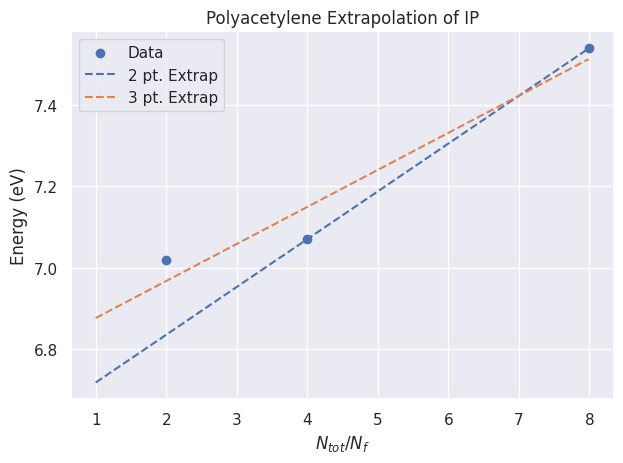

In [22]:
def plotfit(var):
    import matplotlib.pyplot as plt
    x0 = np.array([16/2,16/4,16/8]).reshape(-1, 1)
    y0 = df.loc[var,["LAS (2H)","LAS (4H)","LAS (8H)"]]
    plt.scatter(x0,y0,label="Data")
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x0[:2],y0[:2])
    x = np.arange(1,8,0.01)
    m,b = model.coef_, model.intercept_
    y = m*x + b
    plt.plot(x,y,label="2 pt. Extrap",linestyle="--")
    model.fit(x0,y0)
    m,b = model.coef_, model.intercept_
    y = m*x + b
    plt.plot(x,y,label="3 pt. Extrap",linestyle="--")
    plt.title(f"Polyacetylene Extrapolation of {var}")
    plt.ylabel("Energy (eV)")
    plt.xlabel("$N_{tot}/N_{f}$")
    plt.legend()
    plt.tight_layout()

plotfit("IP")
plt.savefig("figures/hcircle_ip_extrap.png",dpi=500)

 0    3.140000e-16
 1    2.570000e-07
-1    2.670000e-07
Name: dw, dtype: float64


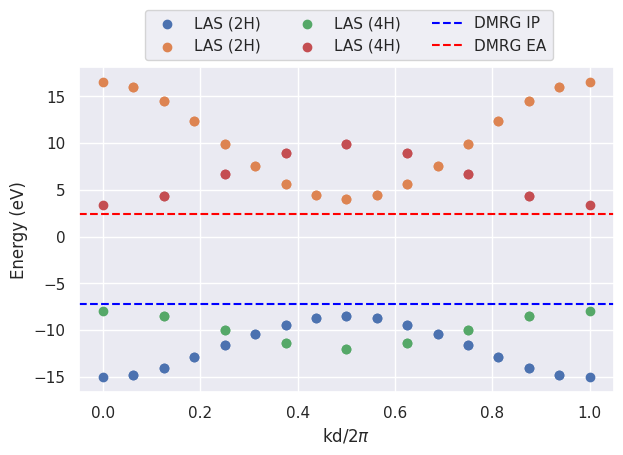

In [27]:
from tools.util import LASdata, DMRGdata, PeriodicData
las = LASdata(pkl_fn="logs/h32_frag2H_dist14_lsi.pkl",pdft=False)
e,k = las.get_homo()
plt.scatter(k,e,label="LAS (2H)")
e,k = las.get_lumo()
plt.scatter(k,e,label="LAS (2H)")

from tools.util import LASdata, DMRGdata, PeriodicData
las = LASdata(pkl_fn="logs/h32_frag4H_dist14_lsi.pkl",pdft=False)
e,k = las.get_homo()
plt.scatter(k,e,label="LAS (4H)")
e,k = las.get_lumo()
plt.scatter(k,e,label="LAS (4H)")

dmrg = DMRGdata("logs/hcircle_dmrg32_d14_m2000.csv",pdft=False)
plt.axhline(dmrg.homo,linestyle="--",color="blue",label="DMRG IP")
plt.axhline(dmrg.lumo,linestyle="--",color="red",label="DMRG EA")

plt.legend(bbox_to_anchor=(0.9,1.2),ncols=3)
plt.ylim(-16,16)

plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
plt.tight_layout()
plt.savefig("figures/h32_las_band_structures.png",dpi=500)

 0    3.140000e-16
 1    2.570000e-07
-1    2.670000e-07
Name: dw, dtype: float64


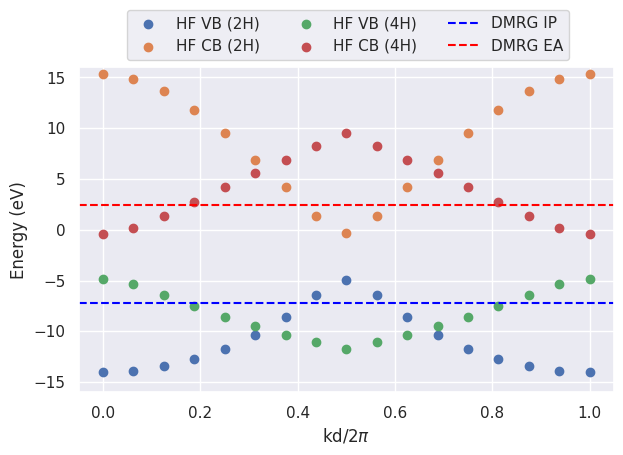

In [35]:
from tools.util import LASdata, DMRGdata, PeriodicData
fnal = "HF"
per = PeriodicData(f"logs/periodic_{fnal}_frag2H_14_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label=f"{fnal} VB (2H)")
e,k = per.get_lumo()
plt.scatter(k,e,label=f"{fnal} CB (2H)")

per = PeriodicData("logs/periodic_HF_frag4H_14_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label=f"{fnal} VB (4H)")
e,k = per.get_lumo()
plt.scatter(k,e,label=f"{fnal} CB (4H)")

dmrg = DMRGdata("logs/hcircle_dmrg32_d14_m2000.csv",pdft=False)
plt.axhline(dmrg.homo,linestyle="--",color="blue",label="DMRG IP")
plt.axhline(dmrg.lumo,linestyle="--",color="red",label="DMRG EA")

plt.legend(bbox_to_anchor=(0.93,1.2),ncols=3)
plt.ylim(-16,16)

plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
plt.tight_layout()
plt.savefig(f"figures/h32_{fnal}_band_structures.png",dpi=500)

 0    3.140000e-16
 1    2.570000e-07
-1    2.670000e-07
Name: dw, dtype: float64


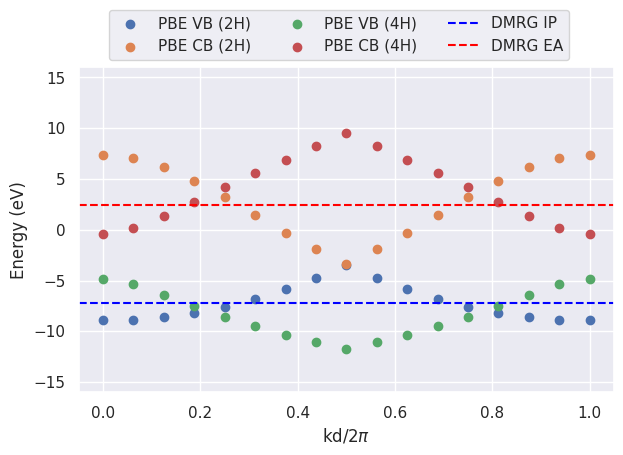

In [36]:
from tools.util import LASdata, DMRGdata, PeriodicData
fnal = "PBE"
per = PeriodicData(f"logs/periodic_{fnal}_frag2H_14_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label=f"{fnal} VB (2H)")
e,k = per.get_lumo()
plt.scatter(k,e,label=f"{fnal} CB (2H)")

per = PeriodicData("logs/periodic_HF_frag4H_14_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label=f"{fnal} VB (4H)")
e,k = per.get_lumo()
plt.scatter(k,e,label=f"{fnal} CB (4H)")

dmrg = DMRGdata("logs/hcircle_dmrg32_d14_m2000.csv",pdft=False)
plt.axhline(dmrg.homo,linestyle="--",color="blue",label="DMRG IP")
plt.axhline(dmrg.lumo,linestyle="--",color="red",label="DMRG EA")

plt.legend(bbox_to_anchor=(0.93,1.2),ncols=3)
plt.ylim(-16,16)

plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
plt.tight_layout()
plt.savefig(f"figures/h32_{fnal}_band_structures.png",dpi=500)

 0    3.140000e-16
 1    2.570000e-07
-1    2.670000e-07
Name: dw, dtype: float64


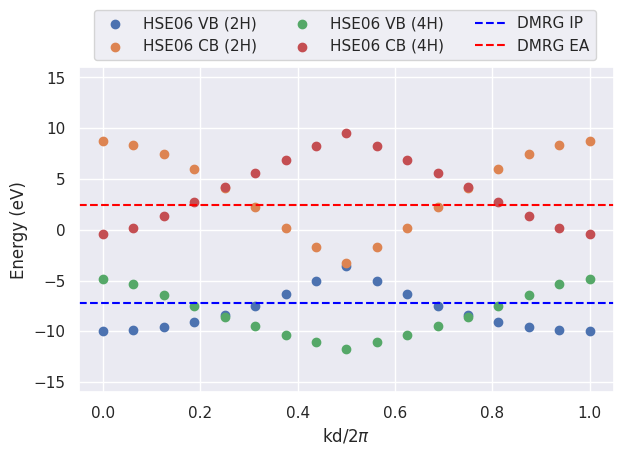

In [40]:
from tools.util import LASdata, DMRGdata, PeriodicData
fnal = "HSE06"
per = PeriodicData(f"logs/periodic_{fnal}_frag2H_14_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label=f"{fnal} VB (2H)")
e,k = per.get_lumo()
plt.scatter(k,e,label=f"{fnal} CB (2H)")

per = PeriodicData("logs/periodic_HF_frag4H_14_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label=f"{fnal} VB (4H)")
e,k = per.get_lumo()
plt.scatter(k,e,label=f"{fnal} CB (4H)")

dmrg = DMRGdata("logs/hcircle_dmrg32_d14_m2000.csv",pdft=False)
plt.axhline(dmrg.homo,linestyle="--",color="blue",label="DMRG IP")
plt.axhline(dmrg.lumo,linestyle="--",color="red",label="DMRG EA")

plt.legend(bbox_to_anchor=(0.98,1.2),ncols=3)
plt.ylim(-16,16)

plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
plt.tight_layout()
plt.savefig(f"figures/h32_{fnal}_band_structures.png",dpi=500)

## Hamiltonian Structure

[-15.39 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96
 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96 -15.02 -15.02 -15.02
 -15.02 -15.02 -15.02 -15.02 -15.02 -15.02 -15.02 -15.02 -15.02 -15.02
 -15.02 -15.02 -15.02]


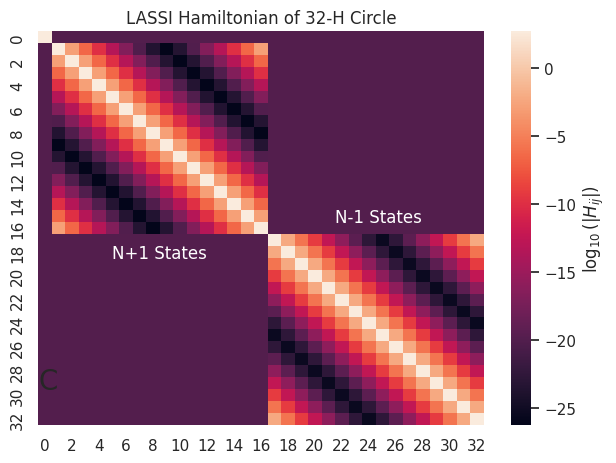

In [41]:
las = LASdata(pkl_fn="logs/h32_frag2H_dist14_lsi.pkl",pdft=False)
H = las.make_h()
for i in range(H.shape[0]):
    H[i][np.where(H[i] != 0)] = np.log(np.abs(H[i][np.where(H[i] != 0)]))
    H[i][np.where(H[i] == 0)] = -20
sns.heatmap(H,cbar_kws={'label': "$\log_{10}(|H_{ij}|)$"})
plt.title("LASSI Hamiltonian of 32-H Circle")
plt.annotate("N+1 States",(5.5,19),c="white")
plt.annotate("N-1 States",(22,16),c="white")
plt.tight_layout()
plt.savefig("figures/h32H.png",dpi=500)

[-15.39 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96
 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96 -14.96 -15.02 -15.02 -15.02
 -15.02 -15.02 -15.02 -15.02 -15.02 -15.02 -15.02 -15.02 -15.02 -15.02
 -15.02 -15.02 -15.02]


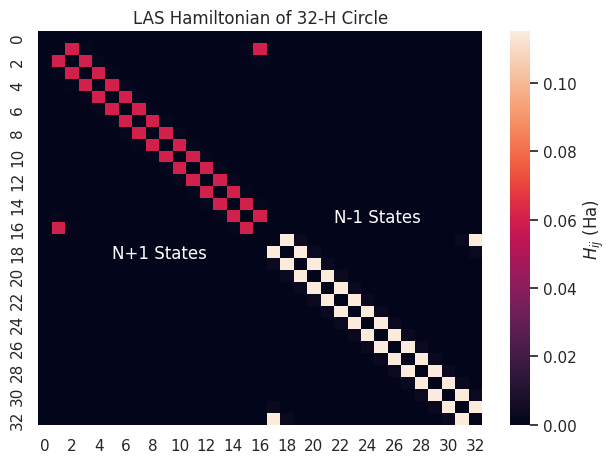

In [42]:
las = LASdata(pkl_fn="logs/h32_frag2H_dist14_lsi.pkl",pdft=False)
H = las.make_h()
H = H - np.diag(np.diag(H))
sns.heatmap(H,cbar_kws={'label': "$H_{ij}$ (Ha)"})
plt.title("LAS Hamiltonian of 32-H Circle")
plt.annotate("N+1 States",(5.5,19),c="white")
plt.annotate("N-1 States",(22,16),c="white")
plt.tight_layout()
plt.savefig("figures/h32H_nodiag.png",dpi=500)